In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('Daily temp in Melbourne.csv')
df.tail()

,Date,Temp
3645,27-12-1990,14.0
3646,28-12-1990,13.6
3647,29-12-1990,13.5
3648,30-12-1990,15.7
3649,31-12-1990,13.0


## Date-time Indexing and Resampling

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-02-01,17.9
2,1981-03-01,18.8
3,1981-04-01,14.6
4,1981-05-01,15.8


In [4]:
df.set_index('Date', inplace=True)

In [5]:
df.head()

,Temp
Date,
1981-01-01,20.7
1981-02-01,17.9
1981-03-01,18.8
1981-04-01,14.6
1981-05-01,15.8


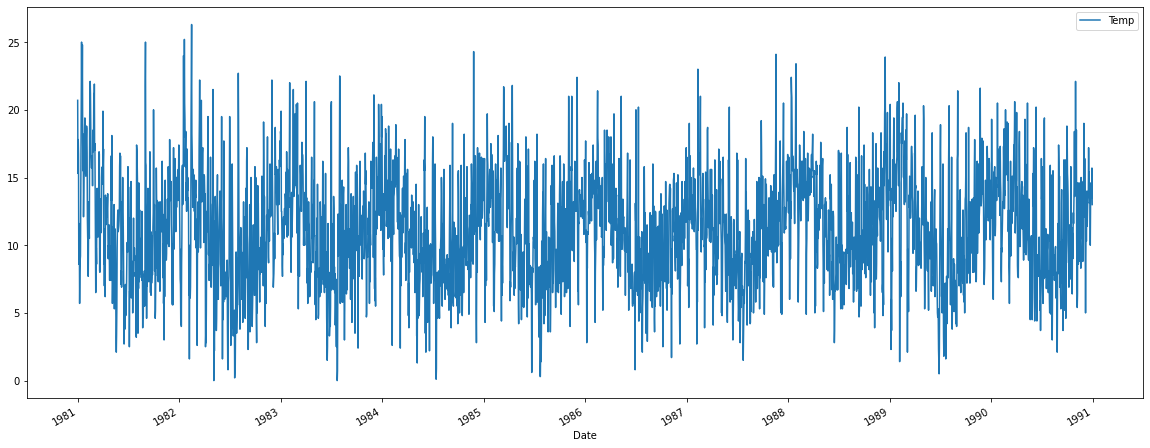

In [6]:
df.plot(figsize=(20,8))

## Converting the data from daily to monthly:

In [7]:
df.Temp.resample('MS').mean()

Date
1981-01-01    15.729032
1981-02-01    15.864286
1981-03-01    12.893548
1981-04-01    11.346667
1981-05-01     9.741935
                ...    
1990-08-01     8.874194
1990-09-01    10.146667
1990-10-01    12.183871
1990-11-01    12.136667
1990-12-01    13.058065
Freq: MS, Name: Temp, Length: 120, dtype: float64

In [8]:
temp = pd.DataFrame(df.Temp.resample('MS').mean())
temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1981-01-01 to 1990-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


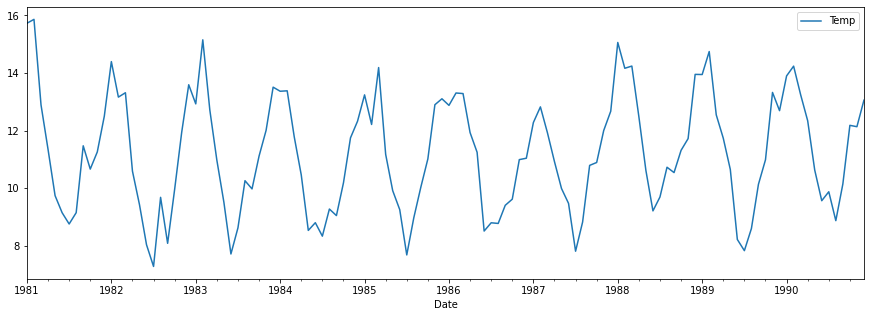

In [9]:
temp.plot(figsize=(15,5))

## Augmented Dickey-Fuller Test:

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
def adfuller_test(timeseries):
    test = adfuller(timeseries)
    results = pd.Series(test[0:4], index=['Test Statistics', 'p-value', 'No.of lags used', 'No.of Observations used'])
    print(results)

In [12]:
adfuller_test(temp)

Test Statistics             -1.703962
p-value                      0.429072
No.of lags used             10.000000
No.of Observations used    109.000000
dtype: float64


p-value > 0.05 indicating the data is not stationary. 

### Differencing inorder to make the data stationary:

In [13]:
temp['Seasonal_temp_diff'] = temp['Temp'] - temp['Temp'].shift(12)
temp.head(15)

,Temp,Seasonal_temp_diff
Date,,
1981-01-01,15.729032,NaN
1981-02-01,15.864286,NaN
1981-03-01,12.893548,NaN
1981-04-01,11.346667,NaN
1981-05-01,9.741935,NaN
1981-06-01,9.150000,NaN
1981-07-01,8.758065,NaN
1981-08-01,9.151613,NaN
1981-09-01,11.473333,NaN


In [14]:
adfuller_test(temp['Seasonal_temp_diff'].dropna())

Test Statistics            -5.625066
p-value                     0.000001
No.of lags used            11.000000
No.of Observations used    96.000000
dtype: float64


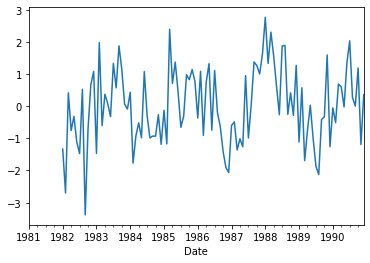

In [15]:
temp['Seasonal_temp_diff'].plot()

## Plotting ACF & PACF:

ARIMA = AR(Auto Regressive) I(Integrated) MA(Moving Average)

p d q = AR(p) I(d) MA(q)

Best way to select p is from pacf_plot 

Best way to select q is from acf_plot

In [16]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

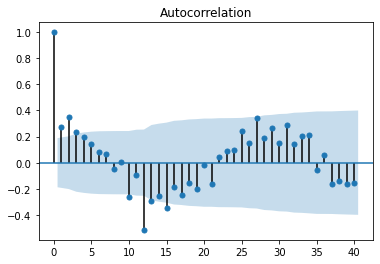

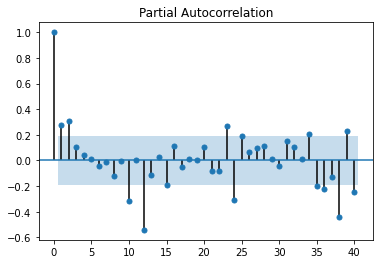

In [17]:
plot_acf(temp['Seasonal_temp_diff'].dropna(), lags=40)
plt.savefig("ACF plot.jpeg")
plt.show()

plot_pacf(temp['Seasonal_temp_diff'].dropna(), lags=40)
plt.savefig("PACF plot.jpeg")
plt.show()

## Splitting the dataset:

In [18]:
training_data=temp['Temp'][0:90]
test_data=temp['Temp'][90:]

## Finding the best p,d,q values:

In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print(pdq)

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [20]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(training_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:685.0937878317789
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:523.8164420233844
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:249.69718579185215
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:170.3394085674081
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:254.90506840860573
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:219.15852098852804
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:181.8442382277379
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:171.39216168650142
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:572.6187762436286
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:431.0760209720925
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:240.1752684465851
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:157.91723727330725
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:251.90998705992348
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:207.68268786086884
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:181.85098690179993
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:167.08759149533483
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:307.89551487641137
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:247.37437728015556

From the above, it is clear that ARIMA(1,0,1)x(0,1,1,12)12 is the best parameter setting since the AIC is very low i.e(156.11)

## Creating Seasonal ARIMA model:

In [21]:
sarimax = sm.tsa.statespace.SARIMAX(training_data, order=(1,0,1), seasonal_order=(0,1,1,12), 
                                   enforce_stationarity=False, enforce_invertibility=False)
model = sarimax.fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Temp   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -74.056
Date:                            Mon, 17 Aug 2020   AIC                            156.112
Time:                                    14:21:20   BIC                            164.748
Sample:                                01-01-1981   HQIC                           159.514
                                     - 06-01-1988                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5259      0.311      1.693      0.091      -0.083       1.135
ma.L1         -0.1615      0.426     -0.379      0.705      -0.997       0.674
ma.S.L12      -0.8300      0.335     -2.474      0.013      -1.488      -0.173
sigma2         0.5317      0.146      3.651      0.000       0.246       0.817
===================================================================================
Ljung-Box (Q):                       43.02   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.34   Prob(JB):                         0.11
Heteroskedasticity (H):               2.51   Skew:                             0.56
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predicting the test data and Forecasting for next 5 yrs:

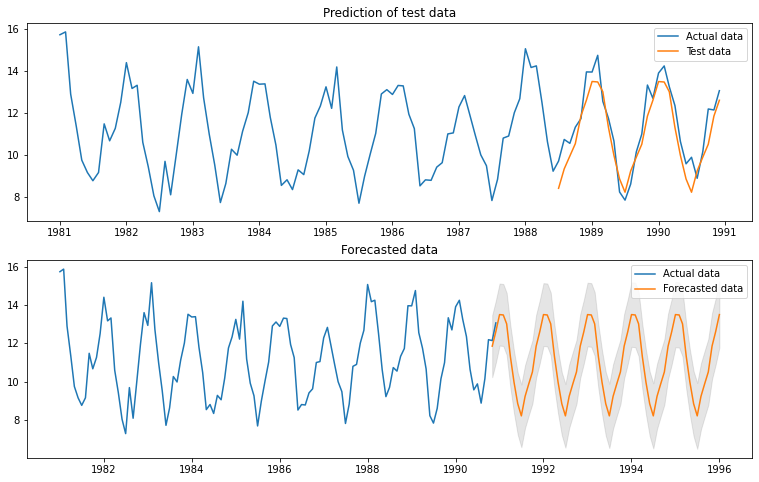

In [23]:
# Predicted the test data:
pred = model.predict(start=90,end=119,dynamic=True)

# Forecasting for the next 5 yrs:
forecast = model.predict(start=118, end=180, dynamic=True)

plt.figure(figsize=(13,8))
plt.subplot(2,1,1)
plt.plot(temp['Temp'], label='Actual data')
plt.plot(pred, label='Test data')
plt.title('Prediction of test data')
plt.legend()

forecast1 = model.get_prediction(start=118, end=180, dynamic=True)
pred_ci = forecast1.conf_int()

plt.subplot(2,1,2)
plt.plot(temp['Temp'], label='Actual data')
plt.plot(forecast, label='Forecasted data')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.title('Forecasted data')
plt.legend()
plt.savefig('Actual data vs Predicted & Forecasted data.jpeg')

## Plotting the diagnostics:

Figure(936x576)


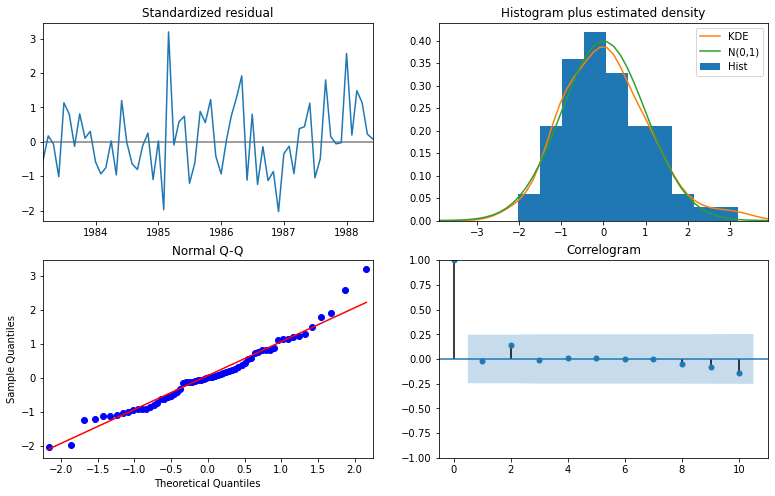

In [24]:
print(model.plot_diagnostics(figsize=(13,8)))
plt.savefig('Diagnostics plot.jpeg')

## Evaluating the model:

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
print('MSE:',mean_squared_error(test_data,pred)*100)
print('RSME:',np.sqrt(mean_squared_error(test_data, pred)*100))

MSE: 71.85832321044519
RSME: 8.476928878458589
